Data Dictionary
Variable Name Description:

- Item_Identifier: Unique product ID
- Item_Weight: Weight of product
- Item_Fat_Content: Whether the product is low fat or regular
- Item_Visibility: The percentage of total display area of all products in a store allocated to the particular product
- Item_Type: The category to which the product belongs
- Item_MRP: Maximum Retail Price (list price) of the product
- Outlet_Identifier: Unique store ID
- Outlet_Establishment_Year: The year in which store was established
- Outlet_Size: The size of the store in terms of ground area covered
- Outlet_Location_Type: The type of area in which the store is located
- Outlet_Type: Whether the outlet is a grocery store or some sort of supermarket
- Item_Outlet_Sales: Sales of the product in the particular store. This is the target variable to be predicted.

# Import

In [1]:
#Import
import matplotlib.pyplot as plt
from sklearn import set_config
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import seaborn as sns
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn import set_config
from sklearn.linear_model import LinearRegression
from sklearn import metrics
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
import joblib
set_config(display='diagram')
## Importing Custom Functions
%reload_ext autoreload
%autoreload 2
from CODE import data_enrichment as de
filename = "Data/sales_predictions.csv"
df = pd.read_csv(filename)


# Functions

In [2]:
def model_metrics(pipe, x_train, y_train, x_test, y_test, 
                       model_name='Regression Model', ):
  ## Train
  mae = mean_absolute_error(y_train, pipe.predict(x_train))
  mse = mean_squared_error(y_train, pipe.predict(x_train))
  rmse = np.sqrt(mean_squared_error(y_train, pipe.predict(x_train)))
  r2 = r2_score(y_train, pipe.predict(x_train))
  print(f'{model_name} Train Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')

  ## Test
  mae = mean_absolute_error(y_test, pipe.predict(x_test))
  mse = mean_squared_error(y_test, pipe.predict(x_test))
  rmse = np.sqrt(mean_squared_error(y_test, pipe.predict(x_test)))
  r2 = r2_score(y_test, pipe.predict(x_test))

  # Display the metrics for the model
  print(f'{model_name} Test Scores')
  print(f'MAE: {mae:,.4f} \nMSE: {mse:,.4f} \nRMSE: {rmse:,.4f} \nR2: {r2:.4f}\n')
  

In [3]:
def get_coefficients(lin_reg):
    coefs = lin_reg.coef_
    coefs = pd.Series(coefs, index=lin_reg.feature_names_in_)
    return coefs

In [4]:
def annotate_hbars(ax, ha='left', va='center', size=12, xytext=(4,0),
                  textcoords='offset points'):
    for bar in ax.patches:
    
        ## calculate center of bar
        bar_ax = bar.get_y() + bar.get_height() / 2
        ## get the value to annotate
        val = bar.get_width()
        if val < 0:
            val_pos = 0
        else:
            val_pos = val
        # ha and va stand for the horizontal and vertical alignment
        ax.annotate(f"{val:.3f}", (val_pos,bar_ax), ha=ha, va=va, size=size,
                        xytext=xytext, textcoords=textcoords)

In [5]:
def get_importances(model, feature_names=None,name='Feature Importance',
                   sort=False, ascending=True):
    
    ## checking for feature names
    if feature_names == None:
        feature_names = model.feature_names_in_
        
    ## Saving the feature importances
    importances = pd.Series(model.feature_importances_, index= feature_names,
                           name=name)
    
    # sort importances
    if sort == True:
        importances = importances.sort_values(ascending=ascending)
        
    return importances



In [6]:
def evaluate_regression(model, X_train,y_train, X_test, y_test): 
    """Evaluates a scikit learn regression model using r-squared and RMSE"""
    
    ## Training Data
    y_pred_train = model.predict(X_train)
    r2_train = metrics.r2_score(y_train, y_pred_train)
    rmse_train = metrics.mean_squared_error(y_train, y_pred_train, 
                                            squared=False)
    
    print(f"Training Data:\tR^2= {r2_train:.2f}\tRMSE= {rmse_train:.2f}")
        
    
    ## Test Data
    y_pred_test = model.predict(X_test)
    r2_test = metrics.r2_score(y_test, y_pred_test)
    rmse_test = metrics.mean_squared_error(y_test, y_pred_test, 
                                            squared=False)
    
    print(f"Test Data:\tR^2= {r2_test:.2f}\tRMSE= {rmse_test:.2f}")


In [7]:
def plot_importance(importances, top_n=None,  figsize=(8,6)):
    # sorting with asc=false for correct order of bars
    if top_n==None:
        ## sort all features and set title
        plot_vals = importances.sort_values()
        title = "All Features - Ranked by Importance"
    else:
        ## sort features and keep top_n and set title
        plot_vals = importances.sort_values().tail(top_n)
        title = f"Top {top_n} Most Important Features"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Importance',
            ylabel='Feature Names',
            title=title)
    ## return ax in case want to continue to update/modify figure
    return ax



In [8]:
def plot_coeffs(coeffs, top_n=None, figsize=(4,5), 
                intercept=False, intercept_name="intercept", 
                annotate=False, ha='left', va='center', size=12, 
                xytext=(4,0), textcoords='offset points'):
    """ Plots the top_n coefficients from a Series, with optional annotations.
    """
    # Drop intercept if intercept=False and 
    if (intercept == False) & (intercept_name in coeffs.index):
        coeffs = coeffs.drop(intercept_name)
    if top_n == None:
        ## sort all features and set title
        plot_vals = coeffs.sort_values()
        title = "All Coefficients - Ranked by Magnitude"
    else:
        ## rank the coeffs and select the top_n
        coeff_rank = coeffs.abs().rank().sort_values(ascending=False)
        top_n_features = coeff_rank.head(top_n)
        
        ## sort features and keep top_n and set title
        plot_vals = coeffs.loc[top_n_features.index].sort_values()
        title = f"Top {top_n} Largest Coefficients"
    ## plotting top N importances
    ax = plot_vals.plot(kind='barh', figsize=figsize)
    ax.set(xlabel='Coefficient', 
            ylabel='Feature Names', 
            title=title)
    ax.axvline(0, color='k')
    if annotate == True:
        annotate_hbars(ax, ha=ha, va=va, size=size, xytext=xytext, textcoords=textcoords)
    return ax


# Checking Versions

In [9]:
# Run the following command on your local computer to check the version of sklearn
import sklearn
!python --version
print(f"sklearn version: {sklearn.__version__}")

Python 3.9.15
sklearn version: 1.1.3


# Data Cleaning

How many Rows and Columns?

In [10]:
rows = len(df)
columns = len(df.columns)
print(f"There are {rows} rows and {columns} columns.")

There are 8523 rows and 12 columns.


-- or

In [11]:
df.shape

(8523, 12)

In [12]:
print(f"The datatype for rows is {type(rows)} and for columns it's {type(columns)}")

The datatype for rows is <class 'int'> and for columns it's <class 'int'>


-- Or

In [13]:
df.dtypes

Item_Identifier               object
Item_Weight                  float64
Item_Fat_Content              object
Item_Visibility              float64
Item_Type                     object
Item_MRP                     float64
Outlet_Identifier             object
Outlet_Establishment_Year      int64
Outlet_Size                   object
Outlet_Location_Type          object
Outlet_Type                   object
Item_Outlet_Sales            float64
dtype: object

**Duplicates?**

- No duplicates no worries

In [14]:
df.duplicated().sum()

0

**Missing values?**

In [15]:
df.isna().sum()

Item_Identifier                 0
Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Identifier               0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

**Dropping Item_Identifier and Outlet_Identifier**

- Dropping the Outlet_Identifier because this particular data does not contribute to the sales predicitons, it's irrelevant to the items being sold.

- Then checking for removal of column with df.drop()

In [16]:
df = df.drop(columns= ["Outlet_Identifier", "Item_Identifier"])

df.head()

,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


In [17]:
#Sucess!
df.isna().sum()

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64

Filling Missing Data

- Checking for missing values.
- Then filling data for missing values and confirming change.

In [18]:
print(df.isna().sum())

Item_Weight                  1463
Item_Fat_Content                0
Item_Visibility                 0
Item_Type                       0
Item_MRP                        0
Outlet_Establishment_Year       0
Outlet_Size                  2410
Outlet_Location_Type            0
Outlet_Type                     0
Item_Outlet_Sales               0
dtype: int64


In [19]:
mean_item_weight = df['Item_Weight'].mean()
df['Item_Weight'].fillna(mean_item_weight, inplace = True)
df['Item_Fat_Content'].value_counts()

Low Fat    5089
Regular    2889
LF          316
reg         117
low fat     112
Name: Item_Fat_Content, dtype: int64

In [20]:
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('low fat', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('LF', 'Low Fat')
df['Item_Fat_Content'] = df['Item_Fat_Content'].replace('reg', 'Regular')

df['Item_Fat_Content'].value_counts()

Low Fat    5517
Regular    3006
Name: Item_Fat_Content, dtype: int64

**Summary Statistics**

In [21]:
df.describe()

,Item_Weight,Item_Visibility,Item_MRP,Outlet_Establishment_Year,Item_Outlet_Sales
count,8523.000000,8523.000000,8523.000000,8523.000000,8523.000000
mean,12.857645,0.066132,140.992782,1997.831867,2181.288914
std,4.226124,0.051598,62.275067,8.371760,1706.499616
min,4.555000,0.000000,31.290000,1985.000000,33.290000
25%,9.310000,0.026989,93.826500,1987.000000,834.247400
50%,12.857645,0.053931,143.012800,1999.000000,1794.331000
75%,16.000000,0.094585,185.643700,2004.000000,3101.296400
max,21.350000,0.328391,266.888400,2009.000000,13086.964800


# Exploratory Visuals

In [22]:
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8523 entries, 0 to 8522
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   Item_Weight                8523 non-null   float64
 1   Item_Fat_Content           8523 non-null   object 
 2   Item_Visibility            8523 non-null   float64
 3   Item_Type                  8523 non-null   object 
 4   Item_MRP                   8523 non-null   float64
 5   Outlet_Establishment_Year  8523 non-null   int64  
 6   Outlet_Size                6113 non-null   object 
 7   Outlet_Location_Type       8523 non-null   object 
 8   Outlet_Type                8523 non-null   object 
 9   Item_Outlet_Sales          8523 non-null   float64
dtypes: float64(4), int64(1), object(5)
memory usage: 666.0+ KB


,Item_Weight,Item_Fat_Content,Item_Visibility,Item_Type,Item_MRP,Outlet_Establishment_Year,Outlet_Size,Outlet_Location_Type,Outlet_Type,Item_Outlet_Sales
0,9.30,Low Fat,0.016047,Dairy,249.8092,1999,Medium,Tier 1,Supermarket Type1,3735.1380
1,5.92,Regular,0.019278,Soft Drinks,48.2692,2009,Medium,Tier 3,Supermarket Type2,443.4228
2,17.50,Low Fat,0.016760,Meat,141.6180,1999,Medium,Tier 1,Supermarket Type1,2097.2700
3,19.20,Regular,0.000000,Fruits and Vegetables,182.0950,1998,NaN,Tier 3,Grocery Store,732.3800
4,8.93,Low Fat,0.000000,Household,53.8614,1987,High,Tier 3,Supermarket Type1,994.7052


C:\Users\caill\AppData\Local\Temp\ipykernel_10448\1528130796.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


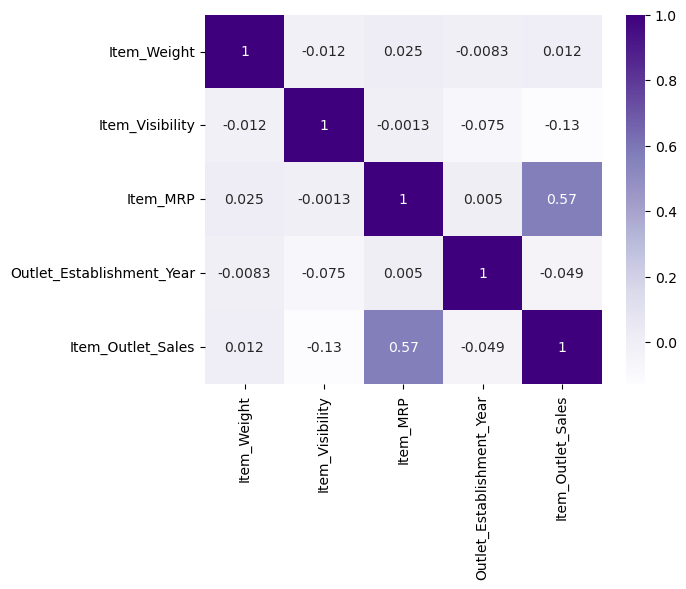

In [23]:
corr = df.corr()
sns.heatmap(corr, cmap = 'Purples', annot = True)
plt.show()

- Checking to see which data has a positive or negative correlation.

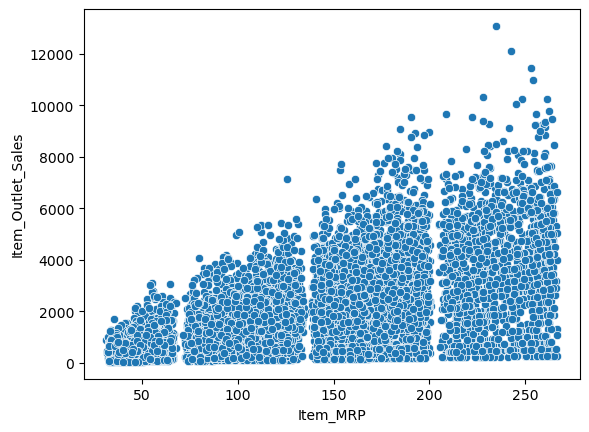

In [24]:
sns.scatterplot(data = df, x = "Item_MRP" , y = "Item_Outlet_Sales")
plt.show()

- This scatterplot shows a positive correlation between Item Outlet Sales and MRP (Highest list price). This means the higher the list price the higher the sale of that item.


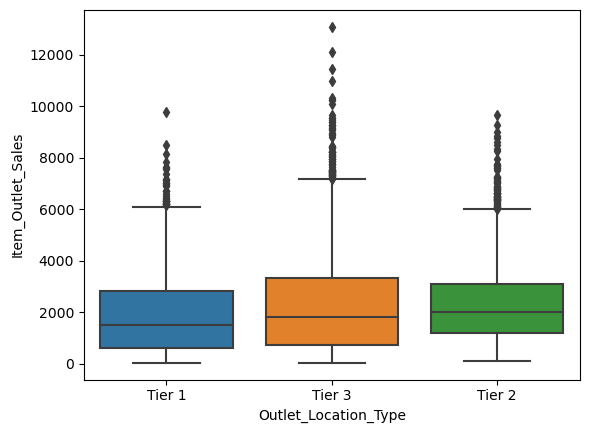

In [25]:
sns.boxplot(data = df, x = "Outlet_Location_Type", y = "Item_Outlet_Sales")
plt.show()

- The average sales are slightly made more at Tier 2 areas than the others. However there are many outliers above the max in all tiers to suggest otherwise.

# Explanatory Visuals

**Checking for styles**

In [26]:
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [ ]:
#checking for trends
sns.pairplot(df.iloc[:, [0, 1, 2, 3, 4, 5, 6, 7, 8, 9]])
plt.show()

In [ ]:
df.info()

- Where have sales been since the start of the busines and what should be done to keep them at a steady rate?

In [ ]:
plt.style.use("seaborn-darkgrid")

In [ ]:
fig, ax = plt.subplots(figsize=(10, 5))
sns.lineplot(data = df, y ="Item_Outlet_Sales", x = "Outlet_Establishment_Year", ci = None, marker ="o")
plt.xlabel("Outlet Establishment Year", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.title("Sales Over the Established Outlet Years", fontsize = 20);
plt.show()

Data shows that sales have been fairly steady since 1985 but took a big dip in sales between 1995-2000. Afterwards data shows that sales shot back up and have been a bit rocky since then. 

Reccomendation : Find out why sales were shot down in between 1995-2000's and what was done differently to bring them back up. Recreate that situation and you may be able to keep sales steady again.

- Will people buy more of a product if it's cheaper?

In [ ]:
plt.style.use("seaborn-pastel")
fig, ax = plt.subplots(figsize=(10, 5))
sns.scatterplot(data = df, x ="Item_MRP", y = "Item_Outlet_Sales")
plt.title("Sales V.S. MRP", fontsize = 20)
plt.xlabel("Item MRP", fontsize = 14)
plt.ylabel("Item Sales (INR)", fontsize = 14)
plt.show()

The data shows more sales occur when the price of the item is higher.

Reccomendation: Make products that are not selling, higher in value. This may spark a change in sales.

# Machine Learning

In [ ]:
#Define X and y
X = df.drop(columns = ["Item_Outlet_Sales"]).copy()

y = df["Item_Outlet_Sales"].copy()


#Train test split the data to prepare for machine learning
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)
X_train.isna().any()


In [ ]:
df["Outlet_Size"].dropna(inplace = True)

In [ ]:
#Create a ColumnTransformer to preprocess the data
cat_selector = make_column_selector(dtype_include = "object")
num_selector = make_column_selector(dtype_include ="number")

cat_selector(X_train)

In [ ]:
# Imputers
freq_imputer = SimpleImputer(strategy='most_frequent')
mean_imputer = SimpleImputer(strategy='mean')

In [ ]:
# Scaler
scaler = StandardScaler()
# One-hot encoder
ohe = OneHotEncoder(handle_unknown='ignore', sparse=False)

In [ ]:
# Numeric pipeline
numeric_pipe = make_pipeline(mean_imputer, scaler)
numeric_pipe

In [ ]:
# Categorical pipeline
categorical_pipe = make_pipeline(freq_imputer, ohe)
categorical_pipe

In [ ]:
# create tuples of (imputer, selector) for each datatype
num_tuple = (numeric_pipe, num_selector)
cat_tuple = (categorical_pipe, cat_selector)
# instantiate ColumnTransformer (processor)
col_transformer = make_column_transformer(num_tuple, cat_tuple, remainder='passthrough')
col_transformer

In [ ]:
#Transform your data and display the result.
col_transformer.fit(X_train)
X_train_imputed = col_transformer.transform(X_train)
X_test_imputed = col_transformer.transform(X_test)
# change the result back to a dataframe to find any missing data
#X_train_imputed = pd.DataFrame(X_train_imputed, columns=X_train.columns)
#X_train_imputed.isna().any()

### Linear Regression

In [ ]:
from sklearn.linear_model import LinearRegression
reg = LinearRegression()

from sklearn.pipeline import make_pipeline
reg_pipe = make_pipeline(scaler, reg)


In [ ]:
#fit on imputed data (other data has null possibly)
reg_pipe.fit(X_train_imputed,y_train)

pred_test = reg_pipe.predict(X_test_imputed)
pred_train = reg_pipe.predict(X_train_imputed)

model_metrics(reg_pipe, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')


In [ ]:
###Regression Tree

dec_tree = DecisionTreeRegressor(random_state = 42)

dec_tree.fit(X_train_imputed, y_train)

train_preds = dec_tree.predict(X_train_imputed)
test_preds = dec_tree.predict(X_test_imputed)

In [ ]:
# evaluating the model
train_score = dec_tree.score(X_train_imputed, y_train)
test_score = dec_tree.score(X_test_imputed, y_test)
print(train_score)
print(test_score)

There seems to be an issue of overfitting in the decision tree. The R2 score in the training is higher than the testing data.

In [ ]:
print(dec_tree.get_depth())

In [ ]:
print(dec_tree.get_n_leaves())

In [ ]:
depths = list(range(2, 40)) # will try every value between 2 and 40

scores = pd.DataFrame(index=depths, columns=['Test Score','Train Score'])
for depth in depths:
    dec_tree = DecisionTreeRegressor(max_depth=depth, random_state=42)
    dec_tree.fit(X_train_imputed, y_train)
    train_score = dec_tree.score(X_train_imputed, y_train)
    test_score = dec_tree.score(X_test_imputed, y_test)
    scores.loc[depth, 'Train Score'] = train_score
    scores.loc[depth, 'Test Score'] = test_score


plt.plot(depths, scores['Test Score'])
plt.xlabel('max_depth')
plt.ylabel('R2');

In [ ]:
#Looking at wich depth precisely has the highest r2 test score
sorted_scores = scores.sort_values(by='Test Score', ascending=False)
sorted_scores.head()

In [ ]:
#Using index with highest test score
dec_tree_5 = DecisionTreeRegressor(max_depth = 5, random_state = 42)
dec_tree_5.fit(X_train_imputed, y_train)
train_5_score = dec_tree_5.score(X_train_imputed, y_train)
test_5_score = dec_tree_5.score(X_test_imputed, y_test)
print(train_5_score)
print(test_5_score)
#Happy balance~

In [ ]:
#R2 and RMSE Score for regression tree
model_metrics(dec_tree_5, X_train_imputed, y_train, X_test_imputed, y_test, model_name='Decision Regression')

The data fits better on the regression tree than the linear model and there are less penalized errors on the regression tree.

### Recommendation of which model to use

I recommend using the decision regression tree. The regression tree will be the best model to use due to the better fit and fewer errors.

# Linear Regression Feature Importance

In [ ]:
pd.set_option('display.max_columns',0)
df

In [ ]:
df.isna().sum()

In [ ]:
df.describe()

In [ ]:
target = 'Item_Outlet_Sales'

grid_spec = {'height_ratios':[0.8,0.2]}
fig, axes = plt.subplots(nrows=2, figsize=(6,5), gridspec_kw=grid_spec)

sns.histplot(data=df, x=target,ax=axes[0])
sns.boxplot(data=df, x=target, ax=axes[1]);

- Average number of sales are at 2000 rupies.

In [ ]:
# ### Train Test Split
## Making the x and y variables
target = "Item_Outlet_Sales"
drop_feats = []

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)
X_train.head(3)

In [ ]:
## making categorical selector and verify it works 
cat_sel = make_column_selector(dtype_include='object')
cat_sel(X_train)

In [ ]:
## making numeric selector and verify it works 
num_sel = make_column_selector(dtype_include='number')
num_sel(X_train)

In [ ]:
## making pipelines for categorical vs numeric data w/o scaling
cat_pipe = make_pipeline(SimpleImputer(strategy='most_frequent', fill_value='MISSING'),
                         OneHotEncoder(drop='first', handle_unknown='ignore', sparse=False))
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


In [ ]:
## making the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),                                      
                                       verbose_feature_names_out=False)
preprocessor

In [ ]:
## fitting column transformer and run get_feature_names_out
preprocessor.fit(X_train)
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=preprocessor.get_feature_names_out(),
                         index=X_test.index)
display(X_train_df)

# Model 1

In [ ]:
from sklearn.linear_model import LinearRegression
lin_reg= LinearRegression()
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [ ]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [ ]:
# accessing the .coef_ 
coeffs = lin_reg.coef_
coeffs

In [ ]:
# Intercept
intercept = lin_reg.intercept_
intercept

In [ ]:
get_coefficients(lin_reg)

In [ ]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [ ]:
## Saving the coefficients
coefs = pd.Series(coeffs, index=lin_reg.feature_names_in_)
coefs

In [ ]:
#Showing sorted coefficients
coefs.sort_values()

Before dropping Item_Type:
- Intercept: Our model assumed a baseline score of -69,552.21
- Unscaled:
   - Positive:
   - Outlet_Type_Supermarket:
      - Type 3: This coefficient tells us that adding a Type 3 supermarket increases sales by 3,814.74 rupies.
      
      - Type 1: Adding a Type 1 supermarket increases sales by 1,511.49 rupies.
           
     - Type 2: Adding a Type 2 supermarket increases sales by 1,278.18 rupies.

In [ ]:
coeff_ranks = coefs.abs().rank().sort_values(ascending=False)
coeff_ranks

- Outlet_Type_Supermarket Type 3 is the most important to the target but Type 1 & 2 are also almost equally important.

In [ ]:
## Getting a list of all of the Item_Type columns
item_types = [i for i in X_train_df.columns if i.startswith('Item_Type')]
item_types

In [ ]:
ax = coefs[item_types].sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0, color='k')
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Item_Type");

- In Item_Type the most more seafood has a positive effect on sales and more dairy has a negative effect.

In [ ]:
## Plotting everything but Item_Type
ax = coefs.drop(item_types).sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without Item_Type");

# Model 2

In [ ]:
lin_reg= LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [ ]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [ ]:
coeffs = lin_reg.coef_
coeffs

In [ ]:
get_coefficients(lin_reg)

In [ ]:
pd.set_option('display.float_format', lambda x: f"{x:,.2f}")

In [ ]:
## Saving the coefficients
coeffs_noint = pd.Series(coeffs, index=lin_reg.feature_names_in_)
coeffs_noint

In [ ]:
ax = coeffs_noint[item_types].sort_values().plot(kind='barh', figsize=(8,10))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Item_Type");

- Item_Type_Seafood is the biggest Item_Type that contributes to higher Item_Outlet_Sales.

In [ ]:
## Plotting everything but Item_Type
ax = coeffs_noint.drop(item_types).sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without Item_Type");

# Model #3 - No Item_Type

In [ ]:
### Train Test Split
## Making x and y variables
target = "Item_Outlet_Sales"
drop_feats = ["Item_Type"]

y = df[target].copy()
X = df.drop(columns=[target, *drop_feats]).copy()

## train-test-split with random state for reproducibility
X_train, X_test, y_train, y_test = train_test_split(X,y, random_state=42)

## Making numeric preprocessing pipeline
num_sel = make_column_selector(dtype_include='number')
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))


## Making categorical preprocessing pipeline
cat_sel = make_column_selector(dtype_include='object')
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(handle_unknown='ignore', sparse=False))

In [ ]:
preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()
X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)

In [ ]:
lin_reg_no = LinearRegression(fit_intercept=False)
lin_reg.fit(X_train_df,y_train)
evaluate_regression(lin_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [ ]:
de.plot_residuals(lin_reg, X_test_df,y_test)

In [ ]:
coeffs_3 = get_coefficients(lin_reg)
coeffs_3.sort_values()

In [ ]:
coeffs_3.sort_values().plot(kind='barh')

In [ ]:
lin_reg.intercept_

# Model 3: Dropping First Duplicate Categories with OneHotEncoder

In [ ]:
## making pipelines for categorical vs numeric data
cat_pipe = make_pipeline(SimpleImputer(strategy='constant',
                                       fill_value='MISSING'),
                         OneHotEncoder(drop='first', sparse=False,
                                      ))
cat_pipe

In [ ]:
num_pipe = make_pipeline(SimpleImputer(strategy='mean'))

## making the preprocessing column transformer
preprocessor = make_column_transformer((num_pipe, num_sel),
                                       (cat_pipe,cat_sel),
                                      verbose_feature_names_out=False)
preprocessor

preprocessor.fit(X_train)
feature_names = preprocessor.get_feature_names_out()

X_train_df = pd.DataFrame(preprocessor.transform(X_train),
                          columns=feature_names,
                         index=X_train.index)
X_test_df = pd.DataFrame(preprocessor.transform(X_test),
                          columns=feature_names,
                         index=X_test.index)
display(X_train_df.head())

In [ ]:
lin_reg_drop = LinearRegression(fit_intercept=False)
lin_reg_drop.fit(X_train_df,y_train)
evaluate_regression(lin_reg_drop, X_train_df, y_train, 
                    X_test_df, y_test)

de.plot_residuals(lin_reg_drop, X_test_df,y_test)

In [ ]:
# extracting and plotting coefficients without Item_Type
coeffs_dropped = get_coefficients(lin_reg_drop)


ax = coeffs_dropped.sort_values().plot(kind='barh')#, figsize=(8,26))
ax.axvline(0)
ax.set(xlabel="Item_Outlet_Sales", title="Coefficients - Without Item_Type");

In [ ]:
ax = plot_coeffs(coeffs_dropped,top_n=10, annotate=True);
ax.set_title('Top 10 Largest Coefficients, w/o Item_Type');
fig_gcf = plt.gcf()

After dropping Item_Type:
- Intercept: Our model assumed a baseline score of 0
- Unscaled:
   - Positive:
   - Outlet_Type_Supermarket:
      - Type 3: This coefficient tells us that adding a Type 3 supermarket increases sales by 3,119.64 rupies.
      
      - Type 1: Adding a Type 1 supermarket increases sales by 1888.05 rupies.
           
     - Type 2: Adding a Type 2 supermarket increases sales by 1,432.61 rupies.

# Random Regression

In [ ]:
rf_reg = RandomForestRegressor()
rf_reg.fit(X_train_df,y_train)
evaluate_regression(rf_reg, X_train_df, y_train, 
                    X_test_df, y_test)

In [ ]:
importances = pd.Series(rf_reg.feature_importances_, index=rf_reg.feature_names_in_)
importances.sort_values()

In [ ]:
get_importances(rf_reg)

In [ ]:
ax = importances.sort_values().plot(kind='barh')#,figsize=(6,4))
ax.axvline(0, color='k')
ax.set(title='Feature Importance - Decision Tree Regressor',ylabel="Feature Name",
      xlabel='Importance');
fig = plt.gcf()

In [ ]:
coeffs_dropped = get_coefficients(lin_reg_drop)

ax = plot_coeffs(coeffs_dropped, annotate=True);
ax.set_title("Largest Coefficients- Without Item_Type");
fig2 = plt.gcf()

In [ ]:
X_train.head()

In [ ]:
evaluate_regression(lin_reg_drop,X_train_df,y_train, X_test_df, y_test)

In [ ]:
evaluate_regression(rf_reg,X_train_df,y_train, X_test_df, y_test)

In [ ]:
import joblib, os

## creating a dictionary of all of the variables to save for later
export = {'X_train':X_train,
         'y_train':y_train,
         'X_test':X_test,
         'y_test':y_test,
          'preprocessor':preprocessor,
         'LinearRegression': lin_reg_drop,
          'RandomForestRegressor':rf_reg}


In [ ]:
folder = 'Models/'
os.makedirs(folder, exist_ok=True)

In [ ]:
fname=folder + 'best-models.joblib'
joblib.dump(export, fname)

In [ ]:
loaded = joblib.load(fname)
loaded.keys()